In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelEncoder
import json
from sklearn.svm import SVC
from wordcloud import STOPWORDS, WordCloud, ImageColorGenerator
import unidecode
import xgboost

import nltk

lemmatizer = nltk.WordNetLemmatizer()

import string

stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.json', 'test.json', 'sample_submission.csv']


In [2]:
data_train = pd.read_json("../input/train.json")
data_test = pd.read_json("../input/test.json")

**Training Data**

Training data contains Cuisine and Ingredients column. 

* Objective is to use this training data to train the model. Model learns from the ingredients to predict the cuisine. 
* This is a classification model building excercise. 
* There are 20 different cuisines to predict. 
* There are about 40,000 rows in the training data and 10,000 in test data. 

In [3]:
data_train.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


In [4]:
print ('Number of rows in training data are',data_train.shape[0]) 

Number of rows in training data are 39774


In [5]:
print('Number of unique cuisines in the training data are',len(data_train.cuisine.unique()))

Number of unique cuisines in the training data are 20


**Test Data**

Test data has about 10,000 rows with only ingredients columns. 

In [6]:
data_test.head()

,id,ingredients
0,18009,"[baking powder, eggs, all-purpose flour, raisi..."
1,28583,"[sugar, egg yolks, corn starch, cream of tarta..."
2,41580,"[sausage links, fennel bulb, fronds, olive oil..."
3,29752,"[meat cuts, file powder, smoked sausage, okra,..."
4,35687,"[ground black pepper, salt, sausage casings, l..."


In [7]:
print ('Number of rows in training data are',data_test.shape[0])

Number of rows in training data are 9944


**Number of Recipes**

Looking at the plot below we can notice that most number of recipes are Italian, followed by Mexian and Southern. Least number of recipies are Brazilian. 

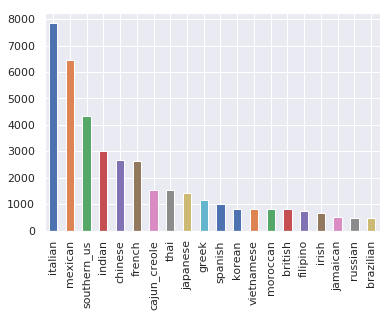

In [8]:
data_train.cuisine.value_counts().plot(kind='bar')

In [9]:
y_train = data_train['cuisine'].apply(lambda x: x.lower())

In [10]:
def clean_text(text):
    text = " ".join([word.lower() for word in text])
    text = "".join([ps.stem(word) for word in text])
    return text

In [11]:
X_train = data_train['ingredients'].apply(lambda x: clean_text(x))
X_test = data_test['ingredients'].apply(lambda x: clean_text(x))

In [12]:
#X_train = data_train['ingredients'].apply(lambda x: ' '.join(lemmatizer.lemmatize(unidecode.unidecode(i)) for i in x).strip().lower())
#X_test = data_test['ingredients'].apply(lambda x: ' '.join(lemmatizer.lemmatize(unidecode.unidecode(i)) for i in x).strip().lower())

In [13]:
X_train.head()

0    romaine lettuce black olives grape tomatoes ga...
1    plain flour ground pepper salt tomatoes ground...
2    eggs pepper salt mayonaise cooking oil green c...
3                       water vegetable oil wheat salt
4    black pepper shallots cornflour cayenne pepper...
Name: ingredients, dtype: object

In [14]:
X_test.head()

0    baking powder eggs all-purpose flour raisins m...
1    sugar egg yolks corn starch cream of tartar ba...
2    sausage links fennel bulb fronds olive oil cub...
3    meat cuts file powder smoked sausage okra shri...
4    ground black pepper salt sausage casings leeks...
Name: ingredients, dtype: object

In [15]:
# Encode Lables of Cusine
labler = LabelEncoder()
y_target = labler.fit_transform(y_train)

In [16]:
# Vectorize Train and Test Data Columns
vectorizer = TfidfVectorizer(binary=True)
X_train_vec = vectorizer.fit_transform(X_train.values)
X_test_vec = vectorizer.transform(X_test.values)

In [17]:
#XGBoost implementation
model = xgboost.XGBClassifier(max_depth = 12, eta = 0.05, subsample = 0.7)
clf = OneVsRestClassifier(model, n_jobs = -1)
clf.fit(X_train_vec, y_target)

OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.05, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=12, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.7),
          n_jobs=-1)

In [18]:
clf_pred = clf.predict(X_test_vec)

In [19]:
y_test = labler.inverse_transform(clf_pred)
test_id = data_test["id"]
submit_xg = pd.DataFrame({'id': test_id, 'cuisine': y_test}, columns=['id', 'cuisine'])
submit_xg.to_csv('xgboost.csv', index=False)